## 퀄리티 팩터: 수익비율 지표 활용(roe, roa) -> 평균 상위 10개 종목 추천

In [1]:
import pandas as pd
from datetime import date, datetime, timedelta
import pandas as pd
import time
import numpy as np
# from sklearn.preprocessing import MinMaxScaler, Normalizer

import FinanceDataReader as fdr
# from pykrx import stock

# import dart_fss as dart
import requests
import bs4
# from urllib.request import urlopen
# import webbrowser
# from selenium import webdriver
import json
# from urllib.request import urlopen
# import xmltodict
# import xml.etree.ElementTree as ET

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# %matplotlib inline

In [2]:
mpl.rcParams['axes.unicode_minus'] = False

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="./malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
nowDate = datetime.today()

startDate = (nowDate - timedelta(90)).strftime("%Y%m%d")
endDate = (nowDate - timedelta(1)).strftime("%Y%m%d")

today = nowDate.strftime("%Y%m%d")
# testStartDate = (nowDate - timedelta(180)).strftime("%Y%m%d")
# testEndDate = (nowDate - timedelta(91)).strftime("%Y%m%d")

In [4]:
print(startDate, endDate, today)

20200402 20200630 20200701


### 1. 데이터 불러오기

In [5]:
resultDf = pd.read_csv("./finalResultDf.csv", encoding="ms949", dtype = {"Ticker":str, "CorpCode":str}, index_col=False)

In [6]:
resultDf.head(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
0,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도,...,8100020626,14480227,23300,337389289100,0.065685,0.017479,42.599051,2.798114,41.652893,2.807348


### 2. 이상치 제거 : lower bound, upper bound

In [7]:
def calcBound(series):
    q3 = series.quantile(0.25)
    q1 = series.quantile(0.75)
    upper = q3 + (q1 - q3) * 1.5
    lower = q1 - (q1 - q3) * 1.5
    return({"upperBound" : upper, "lowerBound" : lower})

In [8]:
ROEBounds = calcBound(resultDf.ROE)
ROABounds = calcBound(resultDf.ROA)

In [9]:
refinedDf = resultDf[(resultDf.ROE < ROEBounds["upperBound"]) & (resultDf.ROE > ROEBounds["lowerBound"])
                 & (resultDf.ROA < ROABounds["upperBound"]) & (resultDf.ROA > ROABounds["lowerBound"])]

In [10]:
refinedDf.head(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
1,211270,KOSDAQ,AP위성,통신 및 방송 장비 제조업,위성통신 단말기,2016-03-04,12월,류장수,http://www.apsi.co.kr,서울특별시,...,38542687,15014804,8160,122520800640,0.013516,0.010419,109.853711,1.484808,3178.833916,16.889108


### 3. ROE, ROA 모두 상위 25% 이내의 종목만 필터링

In [11]:
refinedDf = refinedDf[(refinedDf.ROE > refinedDf.ROE.quantile(0.75))
                   & (refinedDf.ROA > refinedDf.ROA.quantile(0.75))]

In [12]:
refinedDf = refinedDf.reset_index(drop=True)

In [13]:
refinedDf.head()

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,OCF,NumOfIssuedShares,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR
0,079190,KOSDAQ,EMW,통신 및 방송 장비 제조업,휴대폰안테나,2005-11-29,12월,양일규 (단독대표),http://emw.co.kr,인천광역시,...,368976455,31784197,2780,88360067660,0.030445,0.022360,72.664185,2.212295,239.473458,23.439925
1,007700,KOSPI,F&F,봉제의복 제조업,"스포츠웨어(골프웨어) 제조/도서출판(단행본,유아/아동전집류(아인슈타인시리즈),잡지)...",1984-10-04,12월,김창수,http://www.fnf.co.kr,서울특별시,...,4731213514,15400000,92100,1418340000000,0.035673,0.028930,81.083967,2.892473,299.783554,8.921744
2,078930,KOSPI,GS,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시,...,164486000000,92915378,36250,3368182452500,0.033740,0.028764,18.428328,0.621777,20.477016,16.222198
3,078150,KOSDAQ,HB테크놀러지,특수 목적용 기계 제조업,TFT-LCD검사장비,2004-12-08,12월,문성준,http://www.ncbnet.co.kr,충청남도,...,8265641727,78990426,2130,168249607380,0.045720,0.031716,23.258779,1.063393,20.355299,3.113469
4,039570,KOSPI,HDC아이콘트롤스,전기 및 통신 공사업,"기계설비공사, 스마트홈, 지능형 빌딩, SOC",2015-09-24,12월,김성은,http://www.icontrols.co.kr,경기도,...,1783867652,16460000,7900,130034000000,0.034132,0.022602,23.633249,0.806644,72.894421,1.803846


### 4. ROE, ROA 정규화 (0 ~ 1)

In [14]:
def minMaxNorm(inputData):
    maxValue = max(inputData)
    minValue = min(inputData)
    deNormValue = maxValue - minValue
    plusData = inputData - minValue
    outData = inputData
    if deNormValue != 0 :
        outData = plusData / deNormValue
    else:
        pass
    return outData

In [15]:
refinedDf["ROE_Norm"] = minMaxNorm(refinedDf.ROE)
refinedDf["ROA_Norm"] = minMaxNorm(refinedDf.ROA)

### 5. ROE, ROA의 평균 상위 10개 종목 추천

In [16]:
recommendationCount = 10

In [17]:
rcmdDf = refinedDf.copy()

In [18]:
rcmdDf.head(1)

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,Close,MarketValue,ROE,ROA,PER,PBR,PCR,PSR,ROE_Norm,ROA_Norm
0,079190,KOSDAQ,EMW,통신 및 방송 장비 제조업,휴대폰안테나,2005-11-29,12월,양일규 (단독대표),http://emw.co.kr,인천광역시,...,2780,88360067660,0.030445,0.02236,72.664185,2.212295,239.473458,23.439925,0.109089,0.27699


In [19]:
rcmdDf["Norm_Mean"] = (rcmdDf.ROE_Norm + rcmdDf.ROA_Norm) / 2

In [20]:
rcmdDf = rcmdDf.sort_values("Norm_Mean", ascending=False, ignore_index=True)[:recommendationCount]

In [21]:
rcmdDf

,Ticker,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region,...,MarketValue,ROE,ROA,PER,PBR,PCR,PSR,ROE_Norm,ROA_Norm,Norm_Mean
0,178920,KOSDAQ,PI첨단소재,플라스틱제품 제조업,PI필름,2014-12-08,12월,김태림,http://www.skckolonpi.com,충청북도,...,844281757500,0.048742,0.031601,68.077617,3.318232,341.076576,13.701749,0.914977,0.899080,0.907029
1,056190,KOSDAQ,에스에프에이,특수 목적용 기계 제조업,"반도체, Display 제조설비 및 공장자동화기기",2001-12-18,12월,김영민,http://www.sfa.co.kr,경기도,...,1174216452000,0.046169,0.032608,28.969356,1.337496,15.389171,5.800061,0.801666,0.966908,0.884287
2,018120,KOSDAQ,진로발효,알코올음료 제조업,주정,1993-12-29,12월,김종식,http://www.jrdcl.com,경기도,...,196647264000,0.044418,0.033100,60.932950,2.706547,31.151849,6.298752,0.724546,1.000000,0.862273
3,100840,KOSPI,S&TC,일반 목적용 기계 제조업,"공냉식 열교환장치,폐열회수장치 제조",2008-02-22,12월,신경인,http://www.hisnt.com,경상남도,...,115603349400,0.043927,0.033091,10.551575,0.463500,5.539623,2.133721,0.702905,0.999432,0.851168
4,078150,KOSDAQ,HB테크놀러지,특수 목적용 기계 제조업,TFT-LCD검사장비,2004-12-08,12월,문성준,http://www.ncbnet.co.kr,충청남도,...,168249607380,0.045720,0.031716,23.258779,1.063393,20.355299,3.113469,0.781877,0.906840,0.844359
5,094820,KOSDAQ,일진파워,전기 및 통신 공사업,"열교환기,압력용기",2007-11-06,12월,이광섭,http://ijeng.com,울산광역시,...,70719145210,0.043651,0.032936,16.879437,0.736806,25.418910,2.778763,0.690749,0.988958,0.839853
6,005500,KOSPI,삼진제약,의약품 제조업,"의약품(게보린,세트라졸,염산나록손) 제조,판매,수출입,약초재배",1988-06-18,12월,"최승주, 조의환, 장홍순, 최용주",http://www.samjinpharm.co.kr,서울특별시,...,375300000000,0.043233,0.033041,44.222777,1.911900,26.687542,6.502702,0.672348,0.996004,0.834176
7,001820,KOSPI,삼화콘덴서,전자부품 제조업,콘덴서(축전기) 제조,1976-06-26,12월,"오영주, 박진",http://www.samwha.com,경기도,...,554053500000,0.044321,0.032104,87.282627,3.868467,98.308376,12.267188,0.720261,0.932938,0.826599
8,267980,KOSDAQ,매일유업,낙농제품 및 식용빙과류 제조업,"유제품(우유, 분유, 발효유, 치즈, 음료 등)",2017-06-05,12월,김선희,http://www.maeil.com,서울특별시,...,621216129600,0.048062,0.028918,31.283673,1.503562,116.247999,1.735570,0.885038,0.718509,0.801774
9,086450,KOSDAQ,동국제약,의약품 제조업,"인사돌,복합마데카솔,파미레이",2007-05-29,12월,오흥주,http://www.dkpharm.co.kr,서울특별시,...,1074153600000,0.042399,0.031821,68.366944,2.898670,70.936734,9.069398,0.635584,0.913890,0.774737


In [22]:
firstRcmdDf = rcmdDf[0:5]

In [23]:
secondRcmdDf = rcmdDf[5:10].reset_index(drop = True)

### 6. 추천 종목의 최근 3달 가격 추이 시각화

In [24]:
def perfomanceEvaluation(rcmdDf, start, end, fileName):

    resultList = []
    for i in range(0, len(rcmdDf)):
        tmpDf = fdr.DataReader(symbol = rcmdDf.Ticker[i], start = start, end = end)
        performance = tmpDf.Close / tmpDf.Close[0]
        performanceDf = performance.to_frame(name = "Performance")
        performanceDf = pd.concat([tmpDf, performanceDf], axis = 1)
        resultList.append(performanceDf)
    
    meanPerformanceList = []
    for i in range(0, len(resultList[0].Performance)):
        sumPerformance = 0
        for j in range(0, len(resultList)):
            sumPerformance = sumPerformance + resultList[j].Performance[i]
        meanPerformance = (sumPerformance / len(resultList))
        meanPerformanceList.append(meanPerformance)
    meanPerformanceDf = pd.DataFrame(meanPerformanceList)
    
    meanPerformanceDf = pd.DataFrame(meanPerformanceList, columns=["MeanPerformance"])
    meanPerformanceDf.index = [resultList[0].index]
    
    x = resultList[0].index.strftime("%Y-%m-%d")
    y = resultList[0].Performance
    y2 = resultList[1].Performance
    y3 = resultList[2].Performance
    y4 = resultList[3].Performance
    y5 = resultList[4].Performance
    y6 = meanPerformanceDf
    
    plt.figure(figsize = (12,7))
    plt.plot(x,y,"b-",label=rcmdDf.Name[0]+rcmdDf.Ticker[0])
    plt.plot(x,y2, "g-",label=rcmdDf.Name[1]+rcmdDf.Ticker[1])
    plt.plot(x,y3, "r-",label=rcmdDf.Name[2]+rcmdDf.Ticker[2])
    plt.plot(x,y4, "y-",label=rcmdDf.Name[3]+rcmdDf.Ticker[3])
    plt.plot(x,y5, "c-",label=rcmdDf.Name[4]+rcmdDf.Ticker[4])
    plt.plot(x,y6, "k-",label="평균", linewidth=4)
    plt.xlabel("Date")
    plt.ylabel("Performance")
    plt.title("Recommend")
    plt.axhline(y=1.0, color='k')
    plt.xticks(x, x[::10], rotation=45) # set divisor
    plt.locator_params(axis='x', nbins=len(x)/10)  # set divisor 
    plt.legend(loc="best")
    
    plt.savefig(fileName)

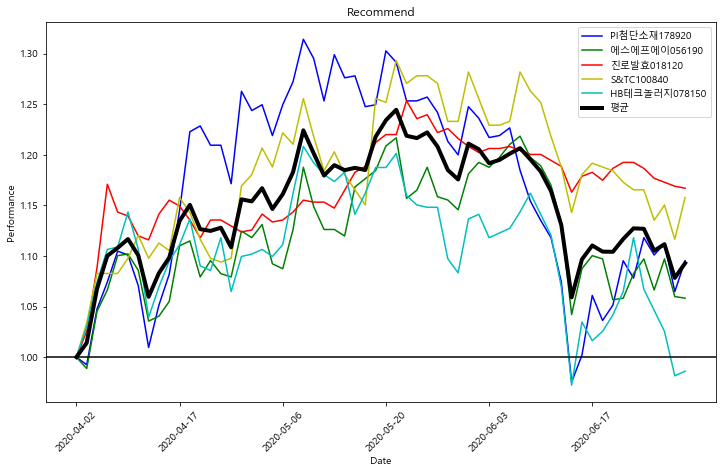

In [25]:
# 1~5위
perfomanceEvaluation(firstRcmdDf, startDate, endDate, (today + "Factor_Quality_1"))

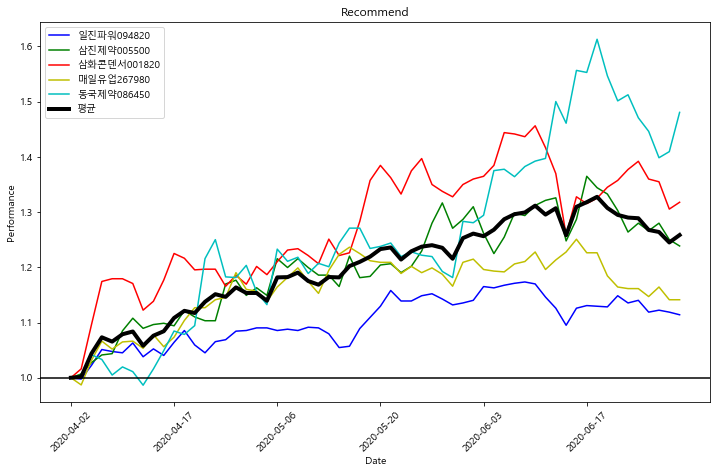

In [26]:
# 6~10위
perfomanceEvaluation(secondRcmdDf, startDate, endDate, (today + "Factor_Quality_2"))

### 7. 테스트용 종목의 최근 3달 가격 추이 시각화 (전략의 유효성 검증)

In [27]:
testResultDf = pd.read_csv("./testFinalResultDf.csv", encoding="ms949", dtype = {"Ticker":str, "CorpCode":str}, index_col=False)

In [28]:
testROEBounds = calcBound(testResultDf.ROE)
testROABounds = calcBound(testResultDf.ROA)

In [29]:
testRefinedDf = testResultDf[(resultDf.ROE < testROEBounds["upperBound"]) & (testResultDf.ROE > testROEBounds["lowerBound"])
                         & (testResultDf.ROA < testROABounds["upperBound"]) & (testResultDf.ROA > testROABounds["lowerBound"])]

In [30]:
testRefinedDf = testRefinedDf[(testRefinedDf.ROE < testRefinedDf.ROE.quantile(0.75))
                           & (testRefinedDf.ROA < testRefinedDf.ROA.quantile(0.75))]

In [31]:
testRefinedDf["ROE_Norm"] = minMaxNorm(testRefinedDf.ROE)
testRefinedDf["ROA_Norm"] = minMaxNorm(testRefinedDf.ROA)

In [32]:
testRcmdDf = testRefinedDf.copy()

In [33]:
testRcmdDf["Norm_Mean"] = (testRcmdDf.ROE_Norm + testRcmdDf.ROA_Norm) / 2

In [34]:
testRcmdDf = testRcmdDf.sort_values("Norm_Mean", ascending=False, ignore_index=True)[:recommendationCount]

In [35]:
testFirstRcmdDf = testRcmdDf[0:5]

In [36]:
testSecondRcmdDf = testRcmdDf[5:10].reset_index(drop = True)

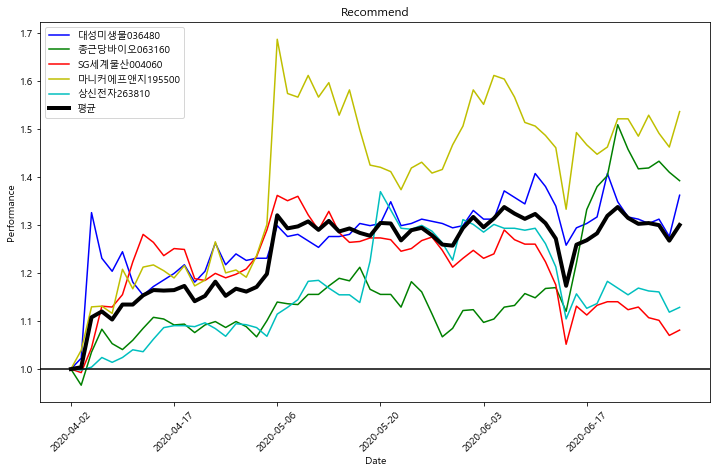

In [37]:
perfomanceEvaluation(testFirstRcmdDf, startDate, endDate, (today + "Factor_Quality_Test_1"))

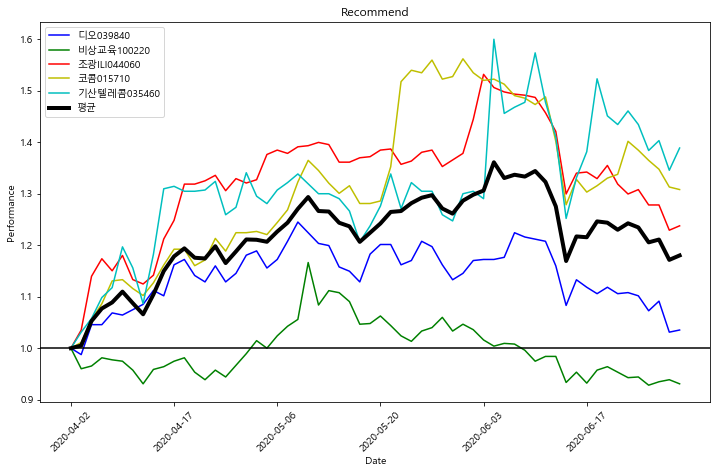

In [38]:
perfomanceEvaluation(testSecondRcmdDf, startDate, endDate, (today + "Factor_Quality_Test_2"))